In [2]:
import os
from collections import defaultdict
import statistics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tools.utils.settings import DefaultPath as defpath
from tools.utils.utils import get_mongodb_collections

In [3]:
# To read a multindex multicolumns dataframe (as those created for the analyses) use the pd.read_csv() attributes "header" and "index_col"
# pd.read_csv('/path/to/complex/table/strange_pivot.csv', header=[0,1,2], index_col=[0,1])

In [4]:
test_name = 'a_test'
dataset = 'gittables'
size = 'standard'
mongoclient, collections = get_mongodb_collections(dataset, size)

In [5]:
test_dir = f'{defpath.data_path.tests}/{test_name}/{dataset}'
results_dir = test_dir + '/results/extracted'

In [6]:
solvers = [('josie', 'set'), ('josie', 'bag'), ('lshforest', 'set'), ('lshforest', 'bag'), ('embedding', 'fasttext')]
q = '50K'

results = pd.read_csv(f'{results_dir}/final_results_q{q}.csv')

In [7]:
results

,query_id,result_id,algorithm,mode,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size
0,349924,561891.0,josie,bag,420.0,360.0,240.0,240.0,240.0
1,349924,270412.0,josie,bag,420.0,360.0,240.0,240.0,240.0
2,349924,229727.0,josie,bag,420.0,360.0,240.0,240.0,240.0
3,349924,551196.0,josie,bag,420.0,360.0,240.0,240.0,240.0
4,349924,440153.0,josie,bag,420.0,360.0,240.0,240.0,240.0
...,...,...,...,...,...,...,...,...,...
1937717,393215,292529.0,lshforest,set,72.0,108.0,72.0,72.0,72.0
1937718,393215,414099.0,lshforest,set,72.0,108.0,72.0,72.0,72.0
1937719,393215,407895.0,lshforest,set,2.0,40.0,72.0,103.0,2.0
1937720,393215,127548.0,lshforest,set,2.0,40.0,72.0,103.0,2.0


In [8]:
results = results.dropna()

In [9]:
results.shape

(1937216, 9)

In [8]:
results['difference_overlap'] = results['algorithm_overlap'] - results['sloth_overlap']
results['algorithm_overlap_norm'] = results['algorithm_overlap'] / (results['sloth_overlap'] + 1)

/tmp/ipykernel_75587/1255061597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['difference_overlap'] = results['algorithm_overlap'] - results['sloth_overlap']
/tmp/ipykernel_75587/1255061597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['algorithm_overlap_norm'] = results['algorithm_overlap'] / (results['sloth_overlap'] + 1)


## I vari metodi per caso ritornano risultati che in realtà non hanno overlap reale?

JOSIE no perché esatto, LSHForest può sbagliare (raramente)

In [10]:
x = []
for am, am_group in results.groupby(by=["algorithm", "mode"]):
    for query_id, q_group in am_group.groupby(by=["query_id"]):
        cnt = ((q_group['sloth_overlap'] == 0)).sum()
        num_query_results = q_group.count().values.tolist()[0]
        x.append([am[0], am[1], query_id[0], num_query_results, cnt, cnt / num_query_results])

x = pd.DataFrame(x, columns=['algorithm', 'mode', 'query_id', 'query_size', 'zero_overlap_cnt', 'zero_overlap_ratio'])

In [11]:
null_ratio_pivot = pd.pivot_table(x, values=['zero_overlap_cnt'], index=['algorithm', 'mode'], aggfunc=['mean', 'std', 'min', 'max'])
null_ratio_pivot

mean              std              min  \
               zero_overlap_cnt zero_overlap_cnt zero_overlap_cnt   
algorithm mode                                                      
josie     bag               0.0              0.0                0   
          set               0.0              0.0                0   
lshforest bag               0.0              0.0                0   
          set               0.0              0.0                0   

                            max  
               zero_overlap_cnt  
algorithm mode                   
josie     bag                 0  
          set                 0  
lshforest bag                 0  
          set                 0

In [12]:
null_ratio_pivot = pd.pivot_table(x, values=['zero_overlap_ratio'], index=['algorithm', 'mode'], aggfunc=['mean', 'std', 'min', 'max'])
null_ratio_pivot

mean                std                min  \
               zero_overlap_ratio zero_overlap_ratio zero_overlap_ratio   
algorithm mode                                                            
josie     bag                 0.0                0.0                0.0   
          set                 0.0                0.0                0.0   
lshforest bag                 0.0                0.0                0.0   
          set                 0.0                0.0                0.0   

                              max  
               zero_overlap_ratio  
algorithm mode                     
josie     bag                 0.0  
          set                 0.0  
lshforest bag                 0.0  
          set                 0.0

In alcuni casi JOSIE sembra sbagliare nonostante sia esatto, probabilmente sono quelli in cui però va in time out e non riesce a ricostruire l'overlap effettivo nel tempo massimo.

In [13]:
x = results[(results['algorithm'] == 'josie') & (results['mode'] == 'set')]

In [15]:
# z = results[(results['sloth_overlap'] == 0) & (results['algorithm_overlap'] != 0) & (results['algorithm'] == 'lshforest') & (results['mode'] == 'bag')]
z = results[(results['sloth_overlap'] > results['algorithm_overlap']) & (results['algorithm'] == 'lshforest') & (results['mode'] == 'bag')]


In [16]:
z

,query_id,result_id,algorithm,mode,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size
491511,393218,373440.0,lshforest,bag,4.0,88.0,143.0,205.0,3.0
491512,393218,287521.0,lshforest,bag,167.0,237.0,143.0,143.0,143.0
491513,393218,55873.0,lshforest,bag,4.0,88.0,143.0,205.0,3.0
491514,393218,328485.0,lshforest,bag,4.0,88.0,143.0,205.0,3.0
491515,393218,16878.0,lshforest,bag,167.0,237.0,143.0,143.0,143.0
...,...,...,...,...,...,...,...,...,...
972086,393215,414099.0,lshforest,bag,77.0,108.0,72.0,72.0,72.0
972087,393215,99379.0,lshforest,bag,3.0,39.0,72.0,77.0,3.0
972088,393215,136214.0,lshforest,bag,3.0,39.0,72.0,77.0,3.0
972089,393215,15064.0,lshforest,bag,3.0,39.0,72.0,77.0,3.0


In [20]:
z[z['query_id'] == 393215]

,query_id,result_id,algorithm,mode,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size
972081,393215,641122.0,lshforest,bag,77.0,108.0,72.0,72.0,72.0
972082,393215,195019.0,lshforest,bag,77.0,108.0,72.0,72.0,72.0
972083,393215,311000.0,lshforest,bag,3.0,39.0,72.0,77.0,3.0
972084,393215,729808.0,lshforest,bag,77.0,108.0,72.0,72.0,72.0
972085,393215,292529.0,lshforest,bag,77.0,108.0,72.0,72.0,72.0
972086,393215,414099.0,lshforest,bag,77.0,108.0,72.0,72.0,72.0
972087,393215,99379.0,lshforest,bag,3.0,39.0,72.0,77.0,3.0
972088,393215,136214.0,lshforest,bag,3.0,39.0,72.0,77.0,3.0
972089,393215,15064.0,lshforest,bag,3.0,39.0,72.0,77.0,3.0
972090,393215,209467.0,lshforest,bag,3.0,39.0,72.0,77.0,3.0


In [24]:
from tools.utils.utils import get_one_document_from_mongodb_by_key
from tools.utils.utils import create_token_set

qdoc = get_one_document_from_mongodb_by_key('_id_numeric', 393215, *collections)
rdoc = get_one_document_from_mongodb_by_key('_id_numeric',311000.0	, *collections)

qset = create_token_set(qdoc['content'], 'bag', qdoc['numeric_columns'])
rset = create_token_set(rdoc['content'], 'bag', rdoc['numeric_columns'])

len(set(qset).intersection(rset))

42

In [25]:
query_id, _id_r = 393215, 311000

In [26]:
doc_table_q = get_one_document_from_mongodb_by_key('_id_numeric', query_id, *collections)
table_q = doc_table_q['content']
numeric_columns_q = doc_table_q['numeric_columns']

# retrieve the result table information from MongoDB
doc_table_r = get_one_document_from_mongodb_by_key('_id_numeric', _id_r, *collections)
table_r = doc_table_r['content']
numeric_columns_r = doc_table_r['numeric_columns']


In [28]:
mode = 'bag'

In [29]:
set_q = create_token_set(table_q, 'set' if mode in ['fasttext', 'tabert'] else mode, numeric_columns_q, blacklist=blacklist)
set_r = create_token_set(table_r, 'set' if mode in ['fasttext', 'tabert'] else mode, numeric_columns_r, blacklist=blacklist)
algorithm_overlap = len(set(set_q).intersection(set_r))

NameError: name 'blacklist' is not defined

In [19]:
# from tools.utils.utils import ResultDatabase
# resultsdb = ResultDatabase('nanni', f'results_table_d{dataset}_s{size}')
# resultsdb.lookup_result_table(245, 645)

In [12]:
print(','.join(map(str, qdoc['numeric_columns'])))
print(','.join(map(str, rdoc['numeric_columns'])))

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,0,0,1,0,1,1,1,1,1,0,1,1,1,1,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,

In [15]:
sum(qdoc['numeric_columns']), sum(rdoc['numeric_columns'])

(417, 304)

In [13]:
pd.DataFrame(qdoc['content'])

,0,1,2,3,4,5,6,7,8,9,...,517,518,519,520,521,522,523,524,525,526
0,low,low,DK,8888,family_member,yes,Hans Solo,Fri Mar 23 00:00:00 UTC 2018,yes,Fri Mar 23 04:45:49 UTC 2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fri Mar 23 05:04:44 UTC 2018,NaN,uuid:aa440b09-6372-4b5c-881a-509b8566d7cc
1,low,low,DK,101010,family_member,yes,Fransis,Tue Mar 27 00:00:00 UTC 2018,yes,Tue Mar 27 03:25:46 UTC 2018,...,NaN,Jaundice,NaN,NaN,NaN,NaN,NaN,Tue Mar 27 03:47:08 UTC 2018,NaN,uuid:345cc282-6313-4399-8042-55fdf5407d7a
2,veryl,veryl,DK,Freddy,family_member,yes,Otis Reading,Tue Mar 27 00:00:00 UTC 2018,yes,Tue Mar 27 03:48:41 UTC 2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tue Mar 27 04:13:05 UTC 2018,NaN,uuid:dee4bd39-90cf-4a85-b38e-f8805fe15443
3,veryl,veryl,DK,Jane doe,parent,yes,Fantastic mr fox,Tue Mar 27 00:00:00 UTC 2018,yes,Tue Mar 27 04:15:03 UTC 2018,...,NaN,NaN,dehydration diarrhea fever,NaN,NaN,NaN,NaN,Tue Mar 27 04:27:19 UTC 2018,NaN,uuid:5fa7be04-6fa8-4a2c-a480-77df97e2f390
4,veryl,veryl,DK,Ross,parent,yes,Polly parrot,Tue Mar 27 00:00:00 UTC 2018,yes,Tue Mar 27 04:27:58 UTC 2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tue Mar 27 04:42:43 UTC 2018,NaN,uuid:0d555a32-b21a-4159-a095-01453a33ab94
5,low,low,DK,Captain Kirk,parent,no,Mr spock,Mon Jun 04 00:00:00 UTC 2018,yes,Mon Jun 04 04:38:29 UTC 2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mon Jun 04 05:07:49 UTC 2018,NaN,uuid:e89be22b-c2fd-438b-9653-39cb025a0d82
6,low,low,DK,Captain Jenway,family_member,dk,Interviewer,Mon Jun 04 00:00:00 UTC 2018,yes,Mon Jun 04 07:13:29 UTC 2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mon Jun 04 07:25:40 UTC 2018,NaN,uuid:2cbcd726-2d3b-4b16-a264-2dcc0cbd027a


In [ ]:
pd.DataFrame(rdoc['content'])

In [ ]:
pd.isna([r[8] for r in qdoc['content']][0])

In [18]:
from tools.utils.utils import apply_sloth

apply_sloth(qdoc['content'], rdoc['content'], qdoc['numeric_columns'], rdoc['numeric_columns'], verbose=True)

Detected 2 seed(s) in 0.003610849380493164 seconds.
Generated 0 candidate(s) in 0.0 seconds.
Verified 0 candidate(s) in 0.0 seconds.
Detected 1 largest overlap(s) in 1.5974044799804688e-05 seconds.
Size of the detected largest overlap(s): 1 columns, 39 rows, 39 cells.
Total elapsed time: 0.003976345062255859 seconds.
          0
0   comment
1   comment
2   comment
3   comment
4   comment
5   comment
6   comment
7   comment
8   comment
9   comment
10  comment
11  comment
12  comment
13  comment
14  comment
15  comment
16  comment
17  comment
18  comment
19  comment
20  comment
21  comment
22  comment
23  comment
24  comment
25  comment
26  comment
27  comment
28  comment
29  comment
30  comment
31  comment
32  comment
33  comment
34    story
35    story
36    story
37    story
38    story


39

In [ ]:
from tools.sloth.sloth import sloth
from tools.utils.utils import prepare_token
table1 = qdoc['content']
table2 = rdoc['content']


num_null = 0

def format_value_for_excluding_nan(t):
    global num_null
    if not t or pd.isna(t):
        num_null += 1
        return f'{t}@{num_null}'
    t = prepare_token(t)
    return t

table1 = [[format_value_for_excluding_nan(row[i]) for row in table1] for i in range(len(table1[0])) if qdoc['numeric_columns'][i] == 0]
table2 = [[format_value_for_excluding_nan(row[i]) for row in table2] for i in range(len(table2[0])) if rdoc['numeric_columns'][i] == 0]

In [ ]:
print(table2[3])

In [ ]:
from tools.sloth.utils import parse_table


pd.DataFrame(parse_table(table1, 3, 0))

In [ ]:
metrics = []
_, metrics = sloth(table1, table2, metrics=metrics, verbose=True)
largest_ov_sloth = metrics[-2]

## Algorithm vs True Overlap

In [20]:
data = [(am[0], am[1], group) for am, group in results.groupby(by=['algorithm', 'mode'])]

In [21]:
results[(results['algorithm'] == 'josie') & (results['mode'] == 'set')].describe()

,query_id,result_id,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size,difference_overlap,algorithm_overlap_norm
count,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000,825.000000
mean,541.997576,504.105455,16.545455,61.369697,199.940606,313.895758,16.545455,-44.824242,0.304645
std,260.106975,280.173061,64.960934,82.612870,281.982803,634.314806,64.960934,52.645263,0.313286
min,23.000000,2.000000,1.000000,1.000000,10.000000,9.000000,1.000000,-416.000000,0.005236
25%,392.000000,269.000000,3.000000,10.000000,61.000000,80.000000,3.000000,-74.000000,0.080000
50%,551.000000,507.000000,5.000000,48.000000,113.000000,169.000000,5.000000,-31.000000,0.153846
75%,728.000000,748.000000,7.000000,85.000000,201.000000,216.000000,7.000000,0.000000,0.500000
max,974.000000,996.000000,677.000000,677.000000,1713.000000,5910.000000,677.000000,21.000000,1.952381


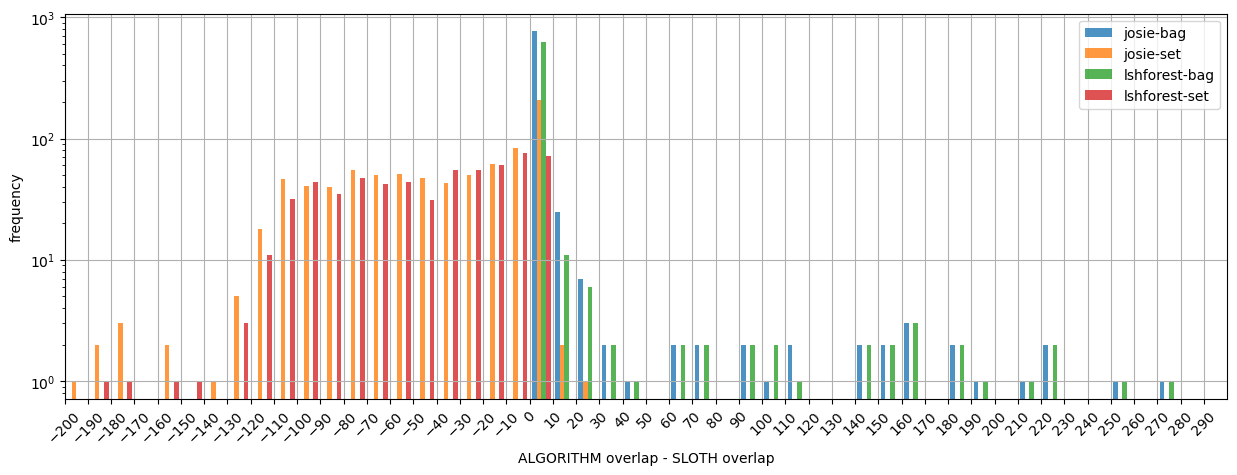

In [22]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(15, 5))
xmin, xmax, step = -200, 300, 10

ax.hist([d[2]['difference_overlap'] for d in data], 
         bins=np.arange(xmin, xmax, step), alpha=0.8, 
         label=[f'{a}-{m}' for a, m, _ in data],
         align='mid')
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax, step))
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)
ax.grid()
ax.set_xlabel('ALGORITHM overlap - SLOTH overlap')
ax.set_ylabel('frequency')

plt.legend()
plt.show()

In [23]:
data = [(am[0], am[1], group) for am, group in results.groupby(by=['algorithm', 'mode'])]

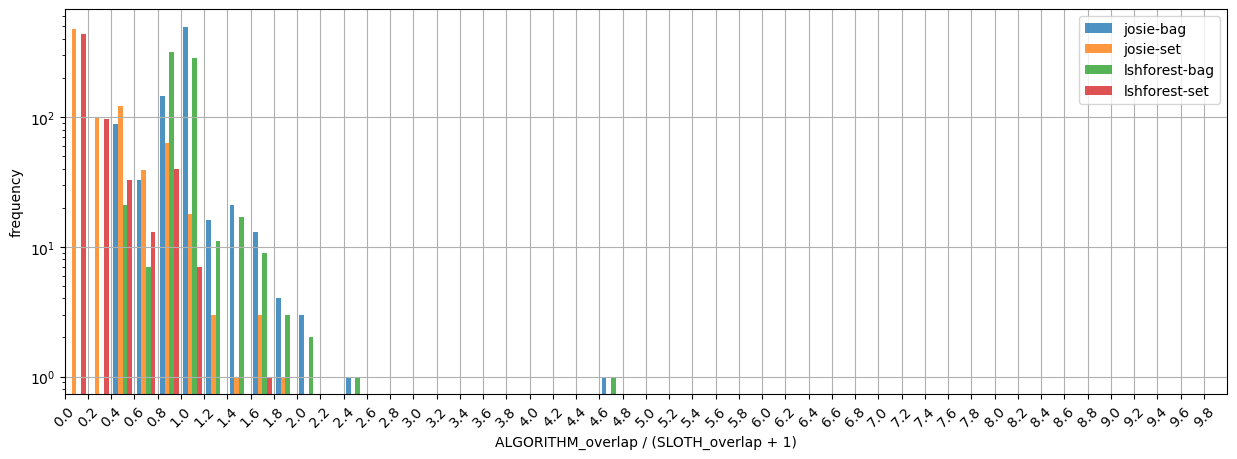

In [24]:
fig, ax = plt.subplots(1, 1, sharey='row', figsize=(15, 5))
xmin, xmax, step = 0, 10, 0.2

ax.hist([d[2]['algorithm_overlap_norm'] for d in data], 
         bins=np.arange(xmin, xmax, step), alpha=0.8, 
         label=[f'{a}-{m}' for a, m, _ in data],
         align='mid')
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax, step))
ax.grid()
ax.set_xlabel('ALGORITHM_overlap / (SLOTH_overlap + 1)')
ax.set_ylabel('frequency')
ax.set_yscale('log')
ax.tick_params(axis='x', rotation=45)

plt.legend()
plt.show()

In [25]:
results[(results['algorithm'] == 'josie') & (results['mode'] == 'bag') & (results['algorithm_overlap'] < results['sloth_overlap'])]

,query_id,result_id,algorithm,mode,algorithm_overlap,sloth_overlap,query_size,res_tab_size,intersection_mode_size,difference_overlap,algorithm_overlap_norm


## Creating Silver Standard

In [26]:
silver_standard = defaultdict(set)

results_ids = results.convert_dtypes().groupby(by='query_id')[['result_id', 'sloth_overlap']]

for query_id, ids_overlaps in results_ids:
    for i in ids_overlaps.values:
        _id, _overlap = i
        silver_standard[query_id].add((_id, _overlap))

for query_id in silver_standard.keys():
    silver_standard[query_id] = sorted(list(silver_standard[query_id]), key=lambda x: x[1], reverse=True)

## Precision at p - $P@p$
Corresponds to the number of relevant results among the top $p$ retrieved documents. Fails to take into account the positions of the relevant documents among the top $p$.Another shortcoming is that on a query with fewer relevant results than $p$, even a perfect system will have a score less than 1.


In [48]:
import multiprocessing as mp

num_cpu = min(os.cpu_count(), 96)

k_precisions = [1, 3, 5, 10]
work = list(silver_standard.keys())

precision_at_p_results = []


def worker(inp):    
    query_id = inp
    
    qss = [x[1] for x in silver_standard[query_id]]
    prec_results = []
        
    for (algorithm, mode), data in results.groupby(by=["algorithm", "mode"]):
        ids = data[data['query_id'] == query_id]['result_id'].values.tolist()
        for p_precision in k_precisions:
            real_topk = [x[0] for x in silver_standard[query_id][:p_precision]]
            precision_at_p = set(real_topk).intersection(ids)
            
            prec_results.append([query_id, len(qss), algorithm, mode, p_precision, len(precision_at_p)])
    return prec_results


with mp.Pool(processes=num_cpu) as pool:
    precision_at_p_results = pool.map(worker, work, chunksize=max(len(work) // num_cpu, 1))
    precision_at_p_results = [x for qres in precision_at_p_results for x in qres]

columns = ['query_id', 'silver_std_size', 'algorithm', 'mode', 'p', 'precision_at_p']
precision_at_p_results = pd.DataFrame(precision_at_p_results, columns=columns)
# precision_at_k = precision_at_k_results.sort_values(by=['silver_std_size', 'query_id'], ascending=False)

In [49]:
precision_at_p_results.head()

,query_id,silver_std_size,algorithm,mode,p,precision_at_p
0,23,7,josie,bag,1,1
1,23,7,josie,bag,3,3
2,23,7,josie,bag,5,5
3,23,7,josie,bag,10,7
4,23,7,josie,set,1,1


In [50]:
patp_pivot = pd.pivot_table(precision_at_p_results, values=['precision_at_p'], index=['algorithm', 'mode'], columns=['p'], aggfunc=['mean', 'std', 'max'])
patp_pivot

mean                                          std  \
               precision_at_p                               precision_at_p   
p                          1         3         5         10             1    
algorithm mode                                                               
josie     bag        0.827957  2.333333  3.655914  6.763441       0.379463   
          set        0.634409  1.849462  2.892473  5.010753       0.484206   
lshforest bag        0.516129  1.215054  1.806452  3.010753       0.502448   
          set        0.365591  0.967742  1.559140  2.494624       0.484206   

                                                        max            
                                             precision_at_p            
p                     3         5         10             1  3  5   10  
algorithm mode                                                         
josie     bag   0.900885  1.470689  2.635039              1  3  5  10  
          set   1.102825  1.741204  2.864682              1  3  5  10  
lshforest bag   1.159549  1.708407  2.803316              1  3  5  10  
          set   1.087994  1.577439  2.429992              1  3  5   9

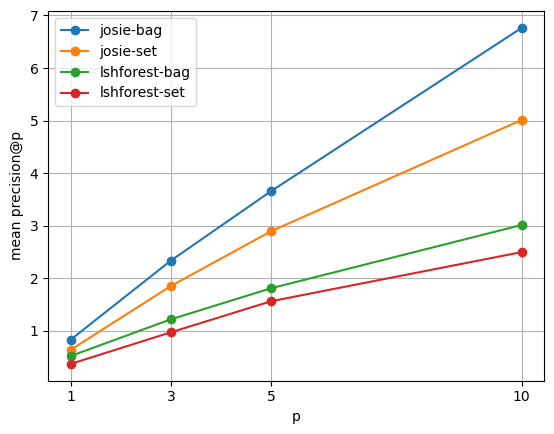

In [51]:
for row, label in zip(patp_pivot['mean', 'precision_at_p'].values, patp_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.xlabel('p')
plt.ylabel('mean precision@p')

plt.legend()
plt.grid()

In [52]:
scaled_patp_pivot = patp_pivot['mean']['precision_at_p'] / np.array([1, 3, 5, 10])
scaled_patp_pivot

p                     1         3         5         10
algorithm mode                                        
josie     bag   0.827957  0.777778  0.731183  0.676344
          set   0.634409  0.616487  0.578495  0.501075
lshforest bag   0.516129  0.405018  0.361290  0.301075
          set   0.365591  0.322581  0.311828  0.249462

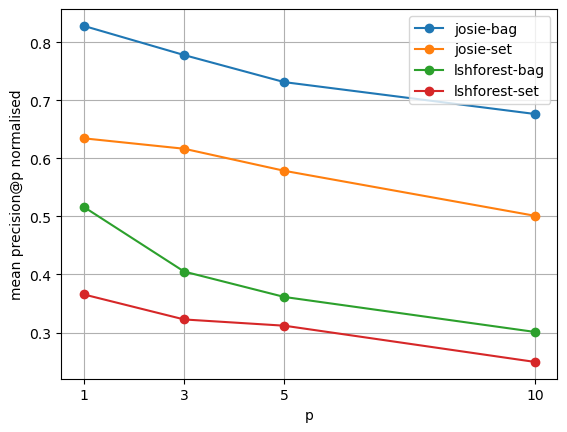

In [53]:
for row, label in zip(scaled_patk_pivot.values, patp_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.xlabel('p')
plt.ylabel('mean precision@p normalised')

plt.legend()
plt.grid()

In [54]:
precision_at_p_results['precision_norm'] = precision_at_p_results['precision_at_p'] / precision_at_p_results['p']

In [56]:
import matplotlib.colors as mcolors
list(mcolors.TABLEAU_COLORS)

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

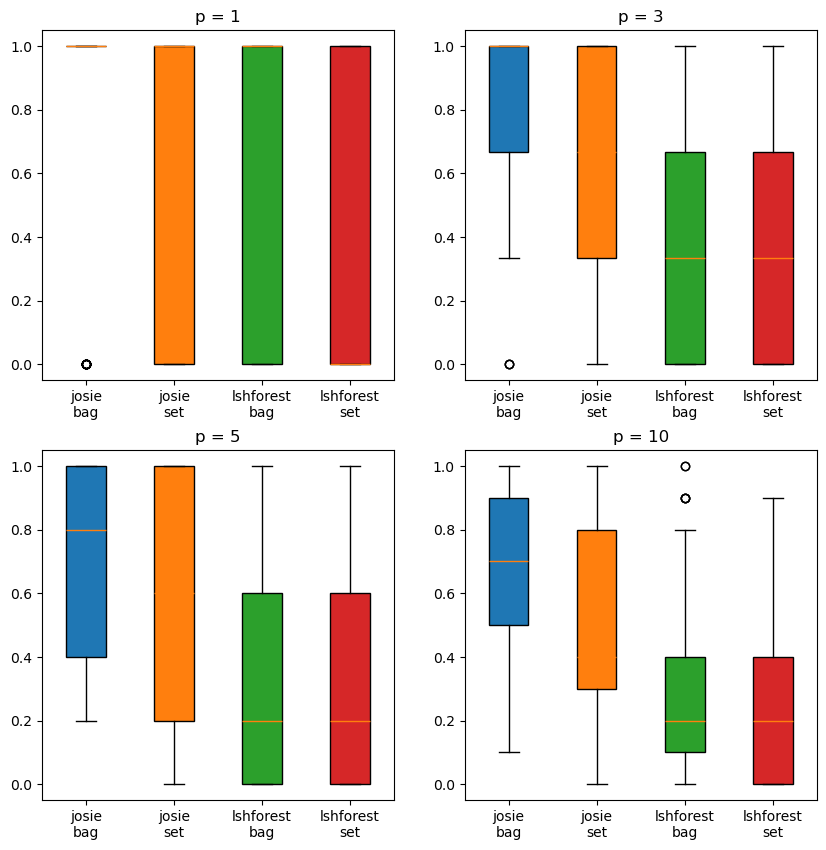

In [65]:
data = [(amp[0], amp[1], amp[2], group) for amp, group in precision_at_p_results.groupby(by=['algorithm', 'mode', 'p'])]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, p in enumerate([1, 3, 5, 10]):
    x = i % 4
    x, y = x // 2, x % 2
    labels = [f'{d[0]}\n{d[1]}' for d in data if d[2] == p]
    colors = list(mcolors.TABLEAU_COLORS)[:len(labels)]

    bplot = axes[x][y].boxplot([d[3]['precision_norm'] for d in data if d[2] == p],
                patch_artist=True,
                labels=labels)
    # axes[x][y].set_xticklabels(labels, rotation=45)
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    axes[x][y].set_title(f'p = {p}')

plt.show()

## Normalized Discontinued Cumulative Gain - $nDCG@p$

Search result lists vary in length depending on the query. Comparing a search engine's performance from one query to the next cannot be consistently achieved using DCG alone, so the cumulative gain at each position for a chosen value of $ p $ should be normalized across queries. This is done by sorting all relevant documents in the corpus by their relative relevance, producing the maximum possible DCG through position $p$, also called Ideal DCG (IDCG) through that position. For a query, the normalized discounted cumulative gain, or nDCG, is computed as: 

$ nDCG_{p} = {DCG_{p} \over IDCG_{p}} $

where $ IDCG_{p} $ is the ideal discounted cumulative gain,

$ IDCG_{p} = \sum_{i=1}^{|REL_{p}|} {2^{rel_{i}} - 1 \over log_{2}(i + 1)}$

where $ REL_{p} $ represents the list of relevant documents (ordered by their relevance) in the corpus up to position $p$

In [ ]:
from math import log2

def ndcg_at_p(true_relevances, scores, p):
    p = min(p, len(true_relevances), len(scores))
    if p <= 0: # because computing nDCG is meaningful only if there is more than one document 
        return 0, 1
    idcg = sum(rel / log2(i + 1) for i, rel in enumerate(true_relevances[:p], start=1))
    dcg = sum(rel / log2(i + 1) for i, rel in enumerate(scores[:p], start=1))
    if idcg < dcg:
        raise ZeroDivisionError()

    return dcg / idcg, p

In [ ]:

def worker_ndcg(query_id):
    p = [1, 3, 5, 10]
    ndcg_res = []
    true_relevances = [x[1] for x in silver_standard[query_id]]
    max_silver_standard = true_relevances[0]
    for (algorithm, mode), data in results.groupby(by=['algorithm', 'mode']):
        r = data[data['query_id'] == query_id][['result_id', 'sloth_overlap']]
        result_relevances = [min(max_silver_standard, x[1]) for x in r.values.tolist()]
        for _p in p:
            try: ndcg, _actual_p = ndcg_at_p(true_relevances, result_relevances, _p)
            except ZeroDivisionError: continue
            ndcg_res.append([query_id, len(true_relevances), algorithm, mode, _p, _p - _actual_p, ndcg])
    return ndcg_res

work = list(silver_standard.keys())

# same work list of precision@p
with mp.Pool(num_cpu) as pool:
    ndcg_results = pool.map(worker_ndcg, work, chunksize=len(work) // num_cpu)
    ndcg_results = [x for qres in ndcg_results for x in qres]


In [ ]:
# res = get_nDCG_p(silver_standard, results, 1, 3, 5, 10)

In [ ]:
df = pd.DataFrame(ndcg_results, columns=['query_id', 'silver_standard_size', 'algorithm', 'mode', 'p', 'missing_p', 'ndcg_p'])

In [ ]:
silver_standard_size_threshold = 0
df_thr = df[df['silver_standard_size'] >= silver_standard_size_threshold]

In [ ]:
ndcg_pivot = df_thr.pivot_table(index=['algorithm', 'mode'], columns=['p'], values=['ndcg_p', 'missing_p'], aggfunc=['mean', 'max']).convert_dtypes()
ndcg_pivot

In [ ]:
ndcg_pivot = df_thr.pivot_table(index=['algorithm', 'mode'], columns=['p'], values=['ndcg_p'], aggfunc=['mean', 'max']).convert_dtypes()
ndcg_pivot

In [ ]:
for row, label in zip(ndcg_pivot['mean', 'ndcg_p'].values, ndcg_pivot.index):
    plt.plot([1, 3, 5, 10], row, 'o-', label=f'{label[0]}-{label[1]}')
plt.xticks([1, 3, 5, 10], [1, 3, 5, 10])
plt.xlabel("p")
plt.ylabel("mean nDCG@p")

plt.legend()
plt.grid()

In [ ]:
data = [(am[0], am[1], group) for am, group in df.groupby(by=['algorithm', 'mode'])]
labels = [f'{d[0]}-{d[1]}' for d in data]
colors = [mcolors.TABLEAU_COLORS['tab:blue'], mcolors.TABLEAU_COLORS['tab:orange'], mcolors.TABLEAU_COLORS['tab:green'], mcolors.TABLEAU_COLORS['tab:red']]

plt.figure(figsize=(10, 5))
bplot = plt.boxplot([d[2]['ndcg_p'] for d in data],
            patch_artist=True,
            labels=labels)
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.legend()
plt.show()

## Analisi tempo

In [ ]:
import itertools

x = [ 
    (
        algorithm, mode, nsamples, 
        pd.read_csv(test_dir + f'/results/base/a{algorithm}_m{mode}_k10_q{nsamples}.csv')['duration'].sum(),  
        pd.read_csv(test_dir + f'/results/base/a{algorithm}_m{mode}_k10_q{nsamples}.csv')['duration'].mean()
    )
    for algorithm, mode, nsamples in itertools.product(['josie', 'lshforest'], ['set', 'bag'], ["1K"])
]

t = pd.DataFrame(x, columns=['algorithm', 'mode', 'num query', 'top-K time total (s)', 'top-K time mean (s)'])
t

In [ ]:
runtime_stat = pd.read_csv('/data4/nanni/tesi-magistrale/data/tests/a_test/wikipedia/statistics/runtime.csv')

In [ ]:
runtime_stat

In [ ]:
runtime_stat['time(s)'].sum() // 3600